In [ ]:
!pip install streamlit pandas numpy plotly wordcloud matplotlib joblib

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc
import joblib
import random

In [ ]:
# Cargar datos
DATA_URL = "/content/Tweets.csv"

In [ ]:
def load_data():
    data = pd.read_csv(DATA_URL)
    data['tweet_created'] = pd.to_datetime(data['tweet_created'])
    return data

data = load_data()

In [ ]:
print(data.dtypes)

tweet_id                                          float64
airline_sentiment                                  object
airline_sentiment_confidence                      float64
negativereason                                     object
negativereason_confidence                         float64
airline                                            object
name                                               object
retweet_count                                       int64
text                                               object
tweet_created                   datetime64[ns, UTC-08:00]
latitude                                          float64
longitude                                         float64
dtype: object


In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,35.888455,-119.273781
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,37.770971,-119.941025
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,35.684863,-119.709299
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,37.061159,-119.279135
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,36.790587,-120.867752


In [ ]:
# Obtener estadísticas descriptivas para variables continuas
print("Estadísticas descriptivas para variables continuas:")
print(data.describe())

Estadísticas descriptivas para variables continuas:
           tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.464000e+04                  14640.000000               10522.000000   
mean   5.692184e+17                      0.900169                   0.638298   
std    7.791112e+14                      0.162830                   0.330440   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685592e+17                      0.692300                   0.360600   
50%    5.694779e+17                      1.000000                   0.670600   
75%    5.698905e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count      latitude     longitude  
count   14640.000000  14640.000000  14640.000000  
mean        0.082650     39.139901    -98.687615  
std         0.745778      3.599528     18.731383  
min         0.000000   

In [ ]:
# Obtener estadísticas descriptivas para variables categóricas
print("\nEstadísticas descriptivas para variables categóricas:")
print(data.describe(include='object'))


Estadísticas descriptivas para variables categóricas:
       airline_sentiment          negativereason airline         name  \
count              14640                    9178   14640        14640   
unique                 3                      10       6         7701   
top             negative  Customer Service Issue  United  JetBlueNews   
freq                9178                    2910    3822           63   

                  text  
count            14640  
unique           14427  
top     @united thanks  
freq                 6  


In [ ]:
########################################
# Mostrar tweet aleatorio
########################################

def show_random_tweet(sentiment):
    random_tweet = data.query("airline_sentiment == @sentiment")[["text"]].sample(n=1).iat[0, 0]
    print(f"Random {sentiment} tweet: {random_tweet}")

show_random_tweet('positive')  # Cambia 'positive' por 'neutral' o 'negative' según sea necesario

Random positive tweet: @SouthwestAir Thanks. I did go through these motions shortly after my flight yesterday. I wonder how quickly flight attendants are notified.


In [ ]:
########################################
# Número de tweets por sentimiento
########################################

def plot_sentiment_count():
    sentiment_count = data['airline_sentiment'].value_counts()
    sentiment_count = pd.DataFrame({'Sentiment': sentiment_count.index, 'Tweets': sentiment_count.values})

    fig = px.bar(sentiment_count, x='Sentiment', y='Tweets', color='Tweets', color_continuous_scale='Blues')
    fig.show()

plot_sentiment_count()

In [ ]:
########################################
# Representación geoespacial de tweets
########################################

def plot_geospatial(hour):
    modified_data = data[data['tweet_created'].dt.hour == hour]
    print(f"{len(modified_data)} tweets between {hour}:00 and {(hour+1)%24}:00")
    fig = px.scatter_mapbox(modified_data, lat="latitude", lon="longitude", hover_name="text", hover_data=["airline", "airline_sentiment"],
                            color_discrete_sequence=["fuchsia"], zoom=3, height=300)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

plot_geospatial(12)  # Cambia el valor de la hora según sea necesario

824 tweets between 12:00 and 13:00


In [ ]:
########################################
# Número total de tweets por aerolínea
########################################

def plot_airline_sentiment_count():
    airline_sentiment_count = data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)
    airline_sentiment_count = pd.DataFrame({'Airline': airline_sentiment_count.index, 'Tweets': airline_sentiment_count.values.flatten()})

    fig = px.bar(airline_sentiment_count, x='Airline', y='Tweets', color='Tweets', color_continuous_scale='Blues', height=500)
    fig.show()

plot_airline_sentiment_count()

In [ ]:
#####################################################
#Breakdown airline by sentiment: individual analysis
#####################################################


# Función para obtener los datos de sentimiento de una aerolínea
def plot_sentiment(airline):
    df = data[data['airline'] == airline]
    count = df['airline_sentiment'].value_counts()
    count = pd.DataFrame({'Sentiment': count.index, 'Tweets': count.values.flatten()})
    return count

# Función para análisis individual de aerolíneas
def plot_individual_analysis(choice, breakdown_type):
    fig_3 = make_subplots(rows=1, cols=len(choice), subplot_titles=choice)
    if breakdown_type == 'Bar plot':
        for i in range(1):
            for j in range(len(choice)):
                sentiment_data = plot_sentiment(choice[j])
                fig_3.add_trace(
                    go.Bar(x=sentiment_data['Sentiment'], y=sentiment_data['Tweets'], showlegend=False),
                    row=i+1, col=j+1
                )
        fig_3.update_layout(height=600, width=800)
        fig_3.show()
    else:
        fig_3 = make_subplots(rows=1, cols=len(choice), specs=[[{'type':'domain'}]*len(choice)], subplot_titles=choice)
        for i in range(1):
            for j in range(len(choice)):
                sentiment_data = plot_sentiment(choice[j])
                fig_3.add_trace(
                    go.Pie(labels=sentiment_data['Sentiment'], values=sentiment_data['Tweets'], showlegend=True),
                    row=i+1, col=j+1
                )
        fig_3.update_layout(height=600, width=800)
        fig_3.show()

# Ejemplo de llamada a la función
choice = ['United', 'Delta']  # Cambia las aerolíneas según sea necesario
breakdown_type = 'Bar plot'  # Cambia el tipo de visualización según sea necesario
plot_individual_analysis(choice, breakdown_type)

In [ ]:
#####################################################
# Breakdown airline by sentiment: comparative analysis
#####################################################

def plot_sentiment():
    count = data.groupby(['airline', 'airline_sentiment']).size().reset_index(name='Tweets')

    fig = px.bar(count, x='airline', y='Tweets', color='airline_sentiment', barmode='group',
                 color_continuous_scale='Blues', height=500)
    fig.show()


plot_sentiment()  # Muestra el sentimiento por aerolínea en una sola gráfica




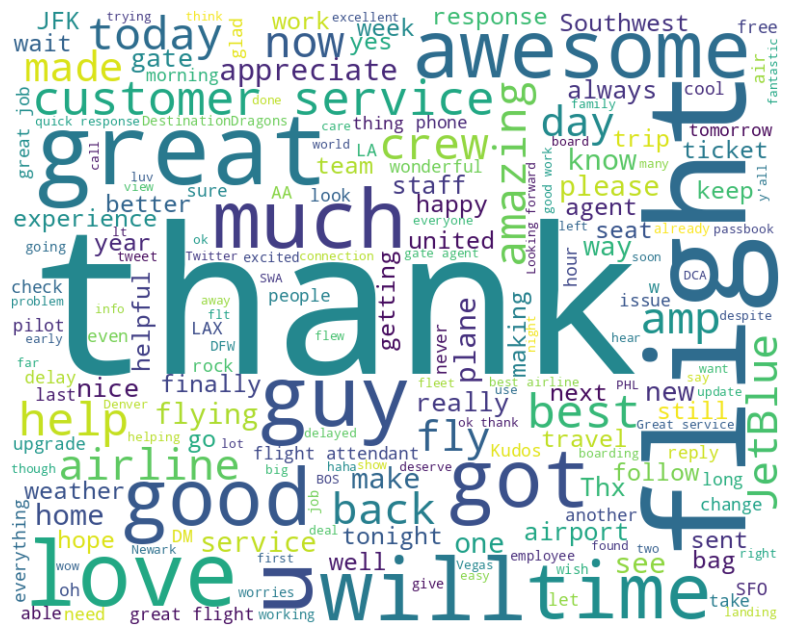

In [ ]:
########################################
# Word Cloud
########################################

def plot_wordcloud(word_sentiment):
    df = data[data['airline_sentiment'] == word_sentiment]
    words = ' '.join(df['text'])
    processed_words = ' '.join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])

    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=640).generate(processed_words)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud('positive')  # Cambia 'positive' por 'neutral' o 'negative' según sea necesario

# **Preprocesamiento de los datos**

In [ ]:
#Separar las características (features) y la variable objetivo (target):
X = data.drop(columns=['airline_sentiment'])
y = data['airline_sentiment']

In [ ]:
  # Dividir los datos en entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definir las columnas categóricas y continuas
categorical_features = ['negativereason', 'airline', 'name']
continuous_features = ['airline_sentiment_confidence', 'negativereason_confidence', 'latitude', 'longitude']

In [ ]:
# Crear transformadores para las columnas categóricas y continuas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
# Combinar los transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', continuous_transformer, continuous_features)
    ]
)

## **SENTIMENT CLASSIFICATION MODEL: LogisticRegression**

In [ ]:
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=1.0, solver='lbfgs', max_iter=300))
])
# Entrenar el modelo
model_lr.fit(X_train, y_train)

# Evaluar el modelo
score = model_lr.score(X_test, y_test)
print(f'Accuracy: {score:.2f}')
y_pred_lr = model_lr.predict(X_test)
print("Reporte de Clasificación - Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.86
Reporte de Clasificación - Logistic Regression
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.66      0.62      0.64       580
    positive       0.55      0.59      0.57       459

    accuracy                           0.86      2928
   macro avg       0.74      0.74      0.74      2928
weighted avg       0.86      0.86      0.86      2928



# **SENTIMENT CLASSIFICATION MODEL: RandomForest**

In [ ]:
# Pipeline para RandomForestClassifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Evaluar el modelo
rf_score = rf_model.score(X_test, y_test)
print(f'RandomForestClassifier Accuracy: {rf_score:.2f}')
y_pred_rf = rf_model.predict(X_test)
print("Reporte de Clasificación - Random Forest")
print(classification_report(y_test, y_pred_rf))

RandomForestClassifier Accuracy: 0.85
Reporte de Clasificación - Random Forest
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.61      0.73      0.67       580
    positive       0.55      0.41      0.47       459

    accuracy                           0.85      2928
   macro avg       0.72      0.71      0.71      2928
weighted avg       0.85      0.85      0.85      2928



# **SENTIMENT CLASSIFICATION MODEL: SVM**

In [ ]:
# Pipeline para SVM
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Evaluar el modelo
svm_score = svm_model.score(X_test, y_test)
print(f'SVM Accuracy: {svm_score:.2f}')
y_pred_svm = svm_model.predict(X_test)
print("Reporte de Clasificación - SVM")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.86
Reporte de Clasificación - SVM
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.67      0.55      0.60       580
    positive       0.54      0.66      0.59       459

    accuracy                           0.86      2928
   macro avg       0.74      0.74      0.73      2928
weighted avg       0.86      0.86      0.86      2928



# **OPTIMIZATION OF MODEL**

## **Parámetros para cada modelo**

In [ ]:
# Parámetros para LogisticRegression
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1.0, 10],
    'classifier__max_iter': [100, 200, 300, 400, 500, 1000, 2000],
    'classifier__solver': ['lbfgs', 'saga', 'liblinear']
}

# Parámetros para RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Parámetros para SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

## **Crear y entrenar los modelos con GridSearchCV**

### **Pipeline for LogisticRegression**

In [ ]:
# Pipeline para LogisticRegression
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(tol=1e-3))
])

# GridSearchCV para LogisticRegression
grid_search_lr = GridSearchCV(estimator=logistic_model, param_grid=param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print(f'Best LogisticRegression params: {grid_search_lr.best_params_}')
print(f'Best LogisticRegression accuracy: {grid_search_lr.best_score_:.2f}')



Best LogisticRegression params: {'classifier__C': 1.0, 'classifier__max_iter': 200, 'classifier__solver': 'saga'}
Best LogisticRegression accuracy: 0.86


In [ ]:
y_pred_lr = grid_search_lr.predict(X_test)
print("Reporte de Clasificación - Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Reporte de Clasificación - Logistic Regression
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.66      0.62      0.64       580
    positive       0.56      0.59      0.57       459

    accuracy                           0.86      2928
   macro avg       0.74      0.74      0.74      2928
weighted avg       0.86      0.86      0.86      2928



###**Pipeline for RandomForestClassifier**

In [ ]:
# Pipeline para RandomForestClassifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV para RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print(f'Best RandomForestClassifier params: {grid_search_rf.best_params_}')
print(f'Best RandomForestClassifier accuracy: {grid_search_rf.best_score_:.2f}')



Best RandomForestClassifier params: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best RandomForestClassifier accuracy: 0.85


In [ ]:
y_pred_rf = grid_search_rf.predict(X_test)
print("Reporte de Clasificación - Random Forest")
print(classification_report(y_test, y_pred_rf))

Reporte de Clasificación - Random Forest
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.61      0.76      0.68       580
    positive       0.56      0.40      0.47       459

    accuracy                           0.86      2928
   macro avg       0.73      0.72      0.72      2928
weighted avg       0.86      0.86      0.85      2928



### **Pipeline for SVM**

In [ ]:
# Pipeline para SVM
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# GridSearchCV para SVM
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
print(f'Best SVM params: {grid_search_svm.best_params_}')
print(f'Best SVM accuracy: {grid_search_svm.best_score_:.2f}')

Best SVM params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best SVM accuracy: 0.85


In [ ]:
y_pred_svm = grid_search_svm.predict(X_test)
print("Reporte de Clasificación - SVM")
print(classification_report(y_test, y_pred_svm))

Reporte de Clasificación - SVM
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.72      0.47      0.56       580
    positive       0.53      0.77      0.63       459

    accuracy                           0.86      2928
   macro avg       0.75      0.74      0.73      2928
weighted avg       0.87      0.86      0.86      2928



# **Resultados de los modelos**

## **Matriz de Confusión**

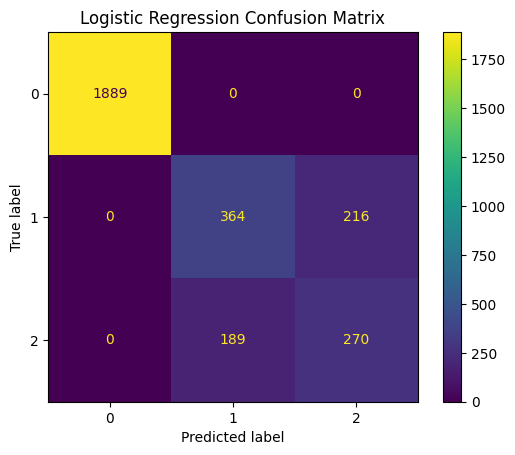

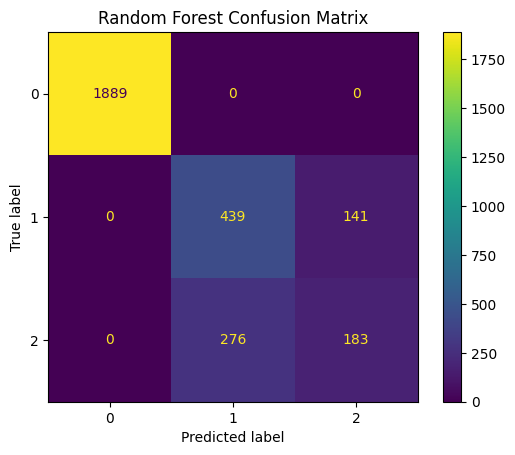

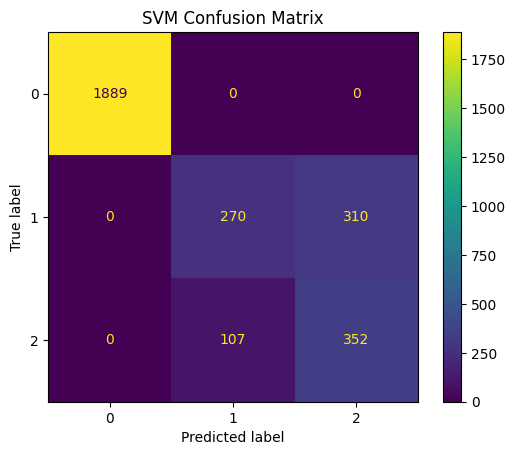

In [ ]:
# Predecir los valores del conjunto de prueba
y_pred_lr = grid_search_lr.predict(X_test)
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_svm = grid_search_svm.predict(X_test)

# Matriz de confusión para LogisticRegression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Matriz de confusión para RandomForestClassifier
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# Matriz de confusión para SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('SVM Confusion Matrix')
plt.show()


**Alternativa con funcion**

In [ ]:
# Función para guardar la matriz de confusión
def save_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.close()

# Guardar las matrices de confusión
save_confusion_matrix(grid_search_lr.best_estimator_, X_test, y_test, 'Logistic Regression')
save_confusion_matrix(grid_search_rf.best_estimator_, X_test, y_test, 'Random Forest')
save_confusion_matrix(grid_search_svm.best_estimator_, X_test, y_test, 'SVM')

## **Curva ROC y AUC**

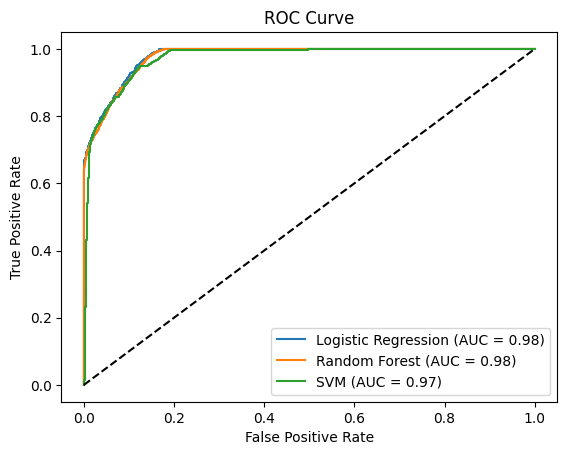

In [ ]:
# Binarizar las etiquetas
y_test_binarized = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades de predicción
y_prob_lr = grid_search_lr.predict_proba(X_test)
y_prob_rf = grid_search_rf.predict_proba(X_test)
y_prob_svm = grid_search_svm.decision_function(X_test)

# Calcular la curva ROC y AUC para cada clase y cada modelo
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[f'lr_{i}'], tpr[f'lr_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_lr[:, i])
    roc_auc[f'lr_{i}'] = auc(fpr[f'lr_{i}'], tpr[f'lr_{i}'])

    fpr[f'rf_{i}'], tpr[f'rf_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
    roc_auc[f'rf_{i}'] = auc(fpr[f'rf_{i}'], tpr[f'rf_{i}'])

    fpr[f'svm_{i}'], tpr[f'svm_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_svm[:, i])
    roc_auc[f'svm_{i}'] = auc(fpr[f'svm_{i}'], tpr[f'svm_{i}'])

# Calcular la curva ROC y AUC promedio (macro) para cada modelo
fpr["macro_lr"], tpr["macro_lr"], _ = roc_curve(y_test_binarized.ravel(), y_prob_lr.ravel())
roc_auc["macro_lr"] = auc(fpr["macro_lr"], tpr["macro_lr"])

fpr["macro_rf"], tpr["macro_rf"], _ = roc_curve(y_test_binarized.ravel(), y_prob_rf.ravel())
roc_auc["macro_rf"] = auc(fpr["macro_rf"], tpr["macro_rf"])

fpr["macro_svm"], tpr["macro_svm"], _ = roc_curve(y_test_binarized.ravel(), y_prob_svm.ravel())
roc_auc["macro_svm"] = auc(fpr["macro_svm"], tpr["macro_svm"])

# Graficar y guardar las curvas ROC
plt.figure()
plt.plot(fpr["macro_lr"], tpr["macro_lr"], label=f'Logistic Regression (AUC = {roc_auc["macro_lr"]:.2f})')
plt.plot(fpr["macro_rf"], tpr["macro_rf"], label=f'Random Forest (AUC = {roc_auc["macro_rf"]:.2f})')
plt.plot(fpr["macro_svm"], tpr["macro_svm"], label=f'SVM (AUC = {roc_auc["macro_svm"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('roc_curve_all_models.png')
plt.show()

**Alternativa: grafica individual**

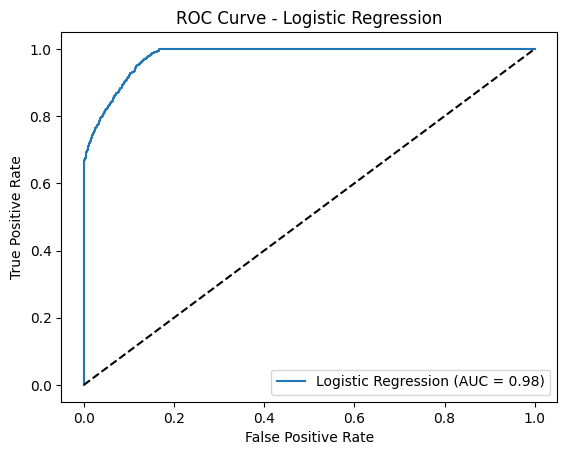

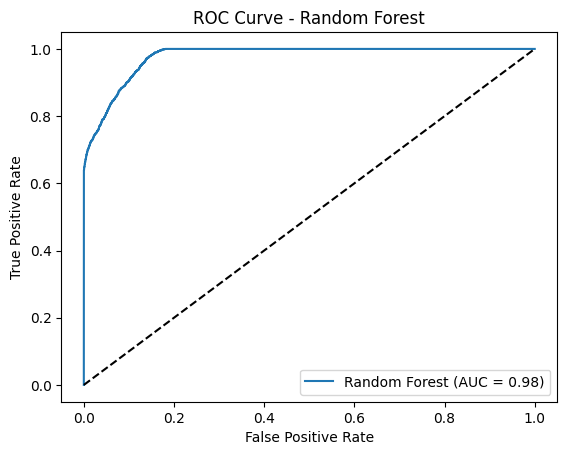

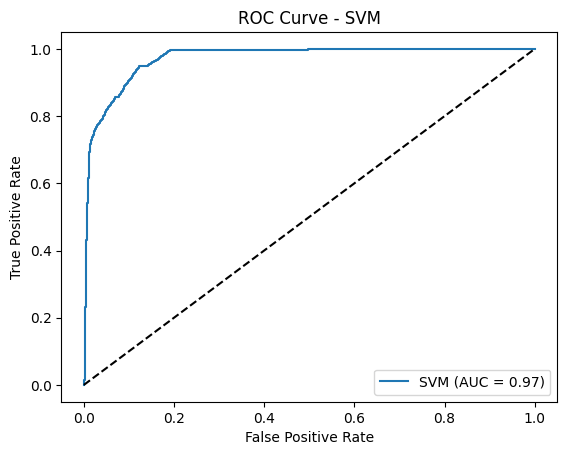

In [ ]:
# Binarizar las etiquetas
y_test_binarized = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
n_classes = y_test_binarized.shape[1]

# Obtener las probabilidades de predicción
y_prob_lr = grid_search_lr.predict_proba(X_test)
y_prob_rf = grid_search_rf.predict_proba(X_test)
y_prob_svm = grid_search_svm.decision_function(X_test)

# Calcular la curva ROC y AUC para cada clase y cada modelo
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[f'lr_{i}'], tpr[f'lr_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_lr[:, i])
    roc_auc[f'lr_{i}'] = auc(fpr[f'lr_{i}'], tpr[f'lr_{i}'])

    fpr[f'rf_{i}'], tpr[f'rf_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
    roc_auc[f'rf_{i}'] = auc(fpr[f'rf_{i}'], tpr[f'rf_{i}'])

    fpr[f'svm_{i}'], tpr[f'svm_{i}'], _ = roc_curve(y_test_binarized[:, i], y_prob_svm[:, i])
    roc_auc[f'svm_{i}'] = auc(fpr[f'svm_{i}'], tpr[f'svm_{i}'])

# Calcular la curva ROC y AUC promedio (macro) para cada modelo
fpr["macro_lr"], tpr["macro_lr"], _ = roc_curve(y_test_binarized.ravel(), y_prob_lr.ravel())
roc_auc["macro_lr"] = auc(fpr["macro_lr"], tpr["macro_lr"])

fpr["macro_rf"], tpr["macro_rf"], _ = roc_curve(y_test_binarized.ravel(), y_prob_rf.ravel())
roc_auc["macro_rf"] = auc(fpr["macro_rf"], tpr["macro_rf"])

fpr["macro_svm"], tpr["macro_svm"], _ = roc_curve(y_test_binarized.ravel(), y_prob_svm.ravel())
roc_auc["macro_svm"] = auc(fpr["macro_svm"], tpr["macro_svm"])

# Graficar las curvas ROC individuales
plt.figure()
plt.plot(fpr["macro_lr"], tpr["macro_lr"], label=f'Logistic Regression (AUC = {roc_auc["macro_lr"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='best')
plt.savefig('roc_curve_logistic_regression.png')
plt.show()

plt.figure()
plt.plot(fpr["macro_rf"], tpr["macro_rf"], label=f'Random Forest (AUC = {roc_auc["macro_rf"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='best')
plt.savefig('roc_curve_random_forest.png')
plt.show()

plt.figure()
plt.plot(fpr["macro_svm"], tpr["macro_svm"], label=f'SVM (AUC = {roc_auc["macro_svm"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='best')
plt.savefig('roc_curve_svm.png')
plt.show()


## **Reporte de Clasificación**

In [ ]:
# Reporte de clasificación para LogisticRegression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Reporte de clasificación para RandomForestClassifier
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Reporte de clasificación para SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Generar el reporte de clasificación para LogisticRegression
report_lr = classification_report(y_test, y_pred_lr)

# Generar el reporte de clasificación para RandomForestClassifier
report_rf = classification_report(y_test, y_pred_rf)

# Generar el reporte de clasificación para SVM
report_svm = classification_report(y_test, y_pred_svm)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.66      0.63      0.64       580
    positive       0.56      0.59      0.57       459

    accuracy                           0.86      2928
   macro avg       0.74      0.74      0.74      2928
weighted avg       0.86      0.86      0.86      2928

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.61      0.76      0.68       580
    positive       0.56      0.40      0.47       459

    accuracy                           0.86      2928
   macro avg       0.73      0.72      0.72      2928
weighted avg       0.86      0.86      0.85      2928

SVM Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1889
     neutral       0.7

# **Guardar los modelos**

### **Guardar los modelos entrenado**s

In [ ]:


# Guardar los modelos
joblib.dump(grid_search_lr.best_estimator_, 'logistic_model.pkl')
joblib.dump(grid_search_rf.best_estimator_, 'rf_model.pkl')
joblib.dump(grid_search_svm.best_estimator_, 'svm_model.pkl')


['svm_model.pkl']

### **Cargar los modelos guardados**

In [ ]:
# Cargar los modelos
logistic_model = joblib.load('logistic_model.pkl')
rf_model = joblib.load('rf_model.pkl')
svm_model = joblib.load('svm_model.pkl')


# **Guardar las visualizaciones de los resultados de los modelos**

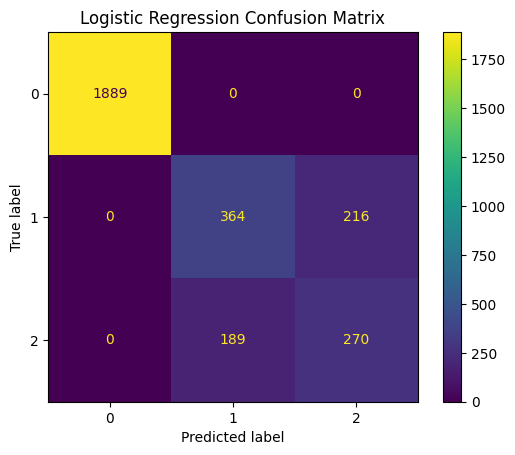

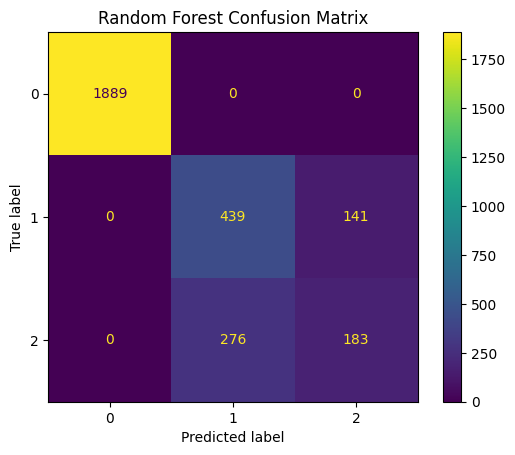

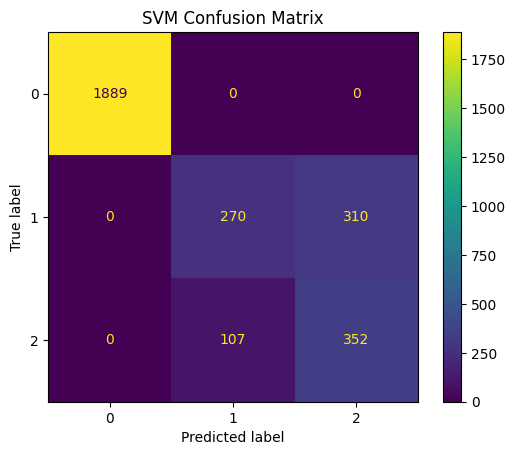

In [ ]:
# Guardar la matriz de confusión
disp_lr.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('logistic_confusion_matrix.png')

disp_rf.plot()
plt.title('Random Forest Confusion Matrix')
plt.savefig('rf_confusion_matrix.png')

disp_svm.plot()
plt.title('SVM Confusion Matrix')
plt.savefig('svm_confusion_matrix.png')

# Guardar el reporte en un archivo de texto
with open('logistic_classification_report.txt', 'w') as f:
    f.write('Logistic Regression Classification Report:\n')
    f.write(report_lr)

# Guardar el reporte en un archivo de texto
with open('rf_classification_report.txt', 'w') as f:
    f.write('Random Forest Classification Report:\n')
    f.write(report_rf)

# Guardar el reporte en un archivo de texto
with open('svm_classification_report.txt', 'w') as f:
    f.write('SVM Classification Report:\n')
    f.write(report_svm)

# **Predicciones individuales y masivas**

### **Predicciones individuales**

In [ ]:
def predict_individual(model, data, feature_names):
    # Convertir los datos a un DataFrame
    df = pd.DataFrame([data], columns=feature_names)

    # Asegurarse de que las columnas categóricas y continuas se procesen correctamente
    df_processed = model.named_steps['preprocessor'].transform(df)

    # Realizar la predicción
    prediction = model.named_steps['classifier'].predict(df_processed)

    return prediction

# Especificar las variables
feature_names = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_created', 'latitude', 'longitude']

# Combina X_test con las predicciones
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_Sentiment'] = y_pred_lr

# Filtra las predicciones positivas
positive_predictions = X_test_with_predictions[X_test_with_predictions['Predicted_Sentiment'] == 'positive']

# Selecciona un registro aleatorio
random_record = positive_predictions.sample(n=1).iloc[0]

# Extrae los valores de las demás variables
data = random_record[feature_names].values.tolist()

# Ejemplo de uso con el mejor modelo encontrado por GridSearchCV
best_model = grid_search_lr.best_estimator_

# Realiza la predicción
prediction = predict_individual(best_model, data, feature_names)
print(f'Data: {data}')
print(f'Predicción: {prediction}')

Data: [5.70002509906838e+17, 1.0, nan, nan, 'Delta', 'redbaronfilms', 0, '@JetBlue Our non-profit ARC would love tickets as we rely on airlines for extractions in saving abducted children and returning them Home!', Timestamp('2015-02-23 15:29:23-0800', tz='UTC-08:00'), 28.7290894049044, -105.784045961871]
Predicción: ['positive']


### **Predicciones masivas (carga de archivo)**

**Muestra de datos**

In [ ]:
import pandas as pd
import random

def predict_individual(model, data, feature_names):
    # Convertir los datos a un DataFrame
    df = pd.DataFrame([data], columns=feature_names)

    # Asegurarse de que las columnas categóricas y continuas se procesen correctamente
    df_processed = model.named_steps['preprocessor'].transform(df)

    # Realizar la predicción
    prediction = model.named_steps['classifier'].predict(df_processed)

    return prediction

# Combina X_test con las predicciones
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_Sentiment'] = y_pred_lr

# Filtra las predicciones positivas, negativas y neutrales
filtered_predictions = X_test_with_predictions[
    X_test_with_predictions['Predicted_Sentiment'].isin(['positive', 'negative', 'neutral'])
]

# Selecciona 23 registros aleatorios
random_records = filtered_predictions.sample(n=23)

# Guarda la muestra de 23 registros como un archivo CSV
random_records.to_csv('muestra_23_registros.csv', index=False)

# Extrae los valores de las demás variables para cada registro
data_list = [record[feature_names].values.tolist() for _, record in random_records.iterrows()]

# Ejemplo de uso con el mejor modelo encontrado por GridSearchCV
best_model = grid_search_lr.best_estimator_

# Realiza la predicción para cada registro y guarda los resultados junto con los datos
results = []
for data in data_list:
    prediction = predict_individual(best_model, data, feature_names)
    results.append({'data': data, 'prediction': prediction[0]})

# Imprime las predicciones junto con los datos utilizados
for i, result in enumerate(results):
    print(f'Predicción {i+1}: {result["prediction"]}, Datos: {result["data"]}')

Predicción 1: negative, Datos: [5.69605359406486e+17, 1.0, 'longlines', 1.0, 'American', 'jddowsett', 0, '@AmericanAir been waiting in line for over an hour in San Antonio, barely moved &amp; only two agents. 30 in front of me &amp; at least 40 behind.', Timestamp('2015-02-22 13:11:15-0800', tz='UTC-08:00'), 40.7636, -73.9911]
Predicción 2: negative, Datos: [5.69673773567382e+17, 1.0, 'Customer Service Issue', 1.0, 'American', 'clara_ennist', 0, '@AmericanAir also the problem is not calling us at all. Other airlines send an automatic call and email, and they rebook as a courtesy.', Timestamp('2015-02-22 17:43:06-0800', tz='UTC-08:00'), 40.6062, -73.9894]
Predicción 3: positive, Datos: [5.68773939754889e+17, 1.0, nan, nan, 'Delta', 'NickMarvalous', 0, '@JetBlue no. Did not catch his name. I am sure Jason will know.', Timestamp('2015-02-20 06:07:29-0800', tz='UTC-08:00'), 36.9269375263455, -100.012007123529]
Predicción 4: negative, Datos: [5.69660029093204e+17, 1.0, 'Cancelled Flight', 0

**Creación de dataset**

In [ ]:
# Guarda data_list en un archivo CSV
data_df = pd.DataFrame(data_list, columns=feature_names)
data_df.to_csv('data_list.csv', index=False)

**Predicción masiva con cargue de archivo**

In [ ]:
import pandas as pd
import random

def predict_individual(model, data, feature_names):
    # Convertir los datos a un DataFrame
    df = pd.DataFrame([data], columns=feature_names)

    # Asegurarse de que las columnas categóricas y continuas se procesen correctamente
    df_processed = model.named_steps['preprocessor'].transform(df)

    # Realizar la predicción
    prediction = model.named_steps['classifier'].predict(df_processed)

    return prediction

# Especificar las variables
feature_names = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_created', 'latitude', 'longitude']

# Cargar data_list desde un archivo CSV en una ruta específica
data_list_path = '/content/data_list.csv'  # Reemplaza con la ruta a tu archivo CSV
data_df = pd.read_csv(data_list_path)

# Asegúrate de que las columnas del archivo CSV coincidan con feature_names
data_list = data_df[feature_names].values.tolist()

# Ejemplo de uso con el mejor modelo encontrado por GridSearchCV
best_model = grid_search_lr.best_estimator_

# Realiza la predicción para cada registro y guarda los resultados junto con los datos
results = []
for data in data_list:
    prediction = predict_individual(best_model, data, feature_names)
    results.append({'data': data, 'prediction': prediction[0]})

# Imprime las predicciones junto con los datos utilizados
for i, result in enumerate(results):
    print(f'Predicción {i+1}: {result["prediction"]}, Datos: {result["data"]}')


Predicción 1: negative, Datos: [5.69605359406486e+17, 1.0, 'longlines', 1.0, 'American', 'jddowsett', 0, '@AmericanAir been waiting in line for over an hour in San Antonio, barely moved &amp; only two agents. 30 in front of me &amp; at least 40 behind.', '2015-02-22 13:11:15-08:00', 40.7636, -73.9911]
Predicción 2: negative, Datos: [5.69673773567382e+17, 1.0, 'Customer Service Issue', 1.0, 'American', 'clara_ennist', 0, '@AmericanAir also the problem is not calling us at all. Other airlines send an automatic call and email, and they rebook as a courtesy.', '2015-02-22 17:43:06-08:00', 40.6062, -73.9894]
Predicción 3: positive, Datos: [5.68773939754889e+17, 1.0, nan, nan, 'Delta', 'NickMarvalous', 0, '@JetBlue no. Did not catch his name. I am sure Jason will know.', '2015-02-20 06:07:29-08:00', 36.9269375263455, -100.012007123529]
Predicción 4: negative, Datos: [5.69660029093204e+17, 1.0, 'Cancelled Flight', 0.3576, 'American', 'TheJoshAbides', 0, '@AmericanAir I made my flight but then